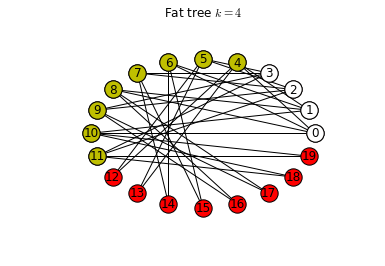

[16, 17, 2, 3]

In [29]:
% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
class FatTree(object):
    def __init__(self,k):
        self.k = k
        self.portNum = k
        self.topo = nx.Graph()
        self.num_core_switch = k**2/4
        self.num_aggregation_switch = k**2/2
        self.num_edge_switch = k**2/2
        
        self.num_switches = self.num_core_switch + self.num_aggregation_switch + self.num_edge_switch
        
        self.core_switches = [i for i in range(0,k**2/4)]
        self.aggregation_switches = [i for i in range(k**2/4,3*(k**2)/4)]
        self.edge_switches = [i for i in range(3*(k**2)/4,5*(k**2)/4)]
        
        
        
        self.generateTopo()
    def generateTopo(self):
        # connect aggregation switches with core switchees
        k = self.k
        for i in range(self.k):
            for sw in range(k**2/4+k/2*i,k**2/4+k/2*(i+1)):
                sw_in_pod = sw%(k/2)
                for core_switch in range(k/2*sw_in_pod,k/2*(sw_in_pod+1)):
                    self.topo.add_edge(sw,core_switch)
        # connect aggregation switches with edge switches
        for i in range(self.k):
            for agg_switch in range(k**2/4+k/2*i,k**2/4+k/2*(i+1)):
                for edge_switch in range(3*k*k/4+k/2*i,3*k*k/4+(k/2)*(i+1)):
                    self.topo.add_edge(agg_switch,edge_switch)
    def show(self):
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos,nodesize=100)
        nx.draw_networkx_nodes(self.topo,pos,self.core_switches,node_color='w')
        nx.draw_networkx_nodes(self.topo,pos,self.aggregation_switches,node_color='y')
        plt.title(r"Fat tree $k = {}$".format(self.k))
        plt.axis('off')
        plt.show()

ft = FatTree(4)
ft.show()
ft.topo.neighbors(9)

In [24]:
# Elements in DC simulation
from DCTopo import FatTree
import simpy
import random
import networkx as nx
class Flow(object):   
    # def __init__(self,src,des,demand,size):
    def __init__(self,time,src,des,size):
        self.time = time
        self.src = src
        
        self.des = des
#        self.demand = demand # bandwidth demand of each flow
        self.size = size # flow size such as 1Gb
    def __repr__(self):
        return "from {} to {},\t size: {:.4f},\t time: {:.2f}".format(self.src,self.des,self.size,self.time)
        
        
class FlowGenerator(object):
    """
    generate a flow to receiver
    the destination of the flow is randomly choosen from left switches
    
    """
    def __init__(self,env,god,out,interval,initial_delay=0,end_time=float('inf'),debug=False):
        self.env = env
        self.god = god
        self.interval = interval
        self.initial_delay = initial_delay
        self.end_time = end_time
        self.out = out # out is a switch
        self.flow_generated = 0
        self.debug = debug
        self.action = self.env.process(self.run())
    def run(self):
        while True:
            yield self.env.timeout(self.initial_delay)
            while self.env.now < self.end_time:
                yield self.env.timeout(self.interval)
                #assert self.out is not None
                # 向out注入flows
                for receiver in self.out:
                    des = receiver.id
                    while des == receiver.id:
                        des = random.randint(0,len(self.god.switches)-1)
                    flow = Flow(self.env.now,receiver.id,des,random.uniform(1,100))
                    if self.debug:
                        print flow
                    self.flow_generated += 1
                    receiver.store.put(flow)

class Link(object):
    # link between adjacent switches
    # src and des are both switches
    # sending flows fron src to des
    def __init__(self,god,env,src,des,rate):
        self.env = env
        self.topo = god.topo.topo # the flow knows all the shortest pathes from src to des......
        self.original = src
        self.src = src
        self.des = des
        self.rate = rate
        self.action = env.process(self.run())
        
    def __repr__(self):
        return "{} to {}".format(self.src,self.des)
    
    def run(self):
        while True:
            flow = yield self.src.store.get() # FIFO temporayily
            #print "Original: ",
            print flow
            
            
            #if flow.des == self.src.id: # the flow arrives at the destination
            #    print flow,
            #    print " arrives"
            #    continue
            # choose the next hop according to the shortest pathes
            #paths = nx.all_shortest_paths(self.topo,self.src.id,self.des.id)
            #next_hops = []
            #for path in paths:
            #    next_hops.append(path[1])
            #if len(next_hops) == 1:
            #    flow.src = next_hops[0]
            #else:
                # 随机选择下一跳
            #    next_hop = random.choice(next_hops)
                # 当前的流发送到下一跳后，流的src更新为到达后的节点的编号（为了方便下一次计算最短路径）
                # 若想知道流最原始的来源，flow.original便是
            #    flow.src = nex_hop
                
            assert self.des is not None
            sending_time = flow.size/self.rate
            yield self.env.timeout(sending_time)
            self.des.store.put(flow)           

class Switch(object):
    
    def __init__(self,env,god,id,qlimit=None,portNum=1,rate=10000):
        self.env = env
        self.id = id
        self.god = god
        self.qlimit = qlimit
        self.store = simpy.Store(env)# store flows
        self.portNum = portNum
        # 先默认link的另一端也是自己，下面会更新
        self.ports = [Link(self.god,env,self,self,rate) for i in range(portNum)] # there are as many links as ports
        self.flow_queue = []
        #self.connect_others()
    # connect other switches with links
#     def connect_others(self):
#         index_of_neighbors = self.god.topo.topo.neighbors(self.id) # len(index_of_neighbors) == slef.portNum
#         neighbor_switches = [sw for sw in self.god.switches if sw.id in index_of_neighbors] # from smaller id to bigger id
#         for i in range(self.portNum):
#             self.ports[i].des = neighbor_switches[i]
    def __repr__(self):
        return "Switch:{}".format(self.id)
        
        
class God(object):
    # topo maybe ft(FatTree Type).topo
    def __init__(self,env,DCTopo,rate):
        self.topo = DCTopo 
        self.env = env
        self.rate = rate
        self.switches = self.generate_switches() # Switch object
        #print self.switches
        self.connect_switches()
        self.generate_flows()
        
    def generate_switches(self):
        num_switches = self.topo.num_switches
        sw = []
        for i in range(num_switches):
            switch = Switch(self.env,self,i,qlimit=None,portNum=self.topo.portNum,rate=self.rate)
            sw.append(switch)
        return sw
    
    def connect_switches(self):
        # print len(self.switches[13].ports)
        #print "All Switches: ",
        #print self.switches 
        for sw in self.switches:
            index_of_neighbors = self.topo.topo.neighbors(sw.id) # len(index_of_neighbors) == sw.portNum
            #print sw,
            #print index_of_neighbors
            neighbor_switches = [switch for switch in self.switches if switch.id in index_of_neighbors]
            #print sw,
            #print neighbor_switches
            
            for i in range(len(neighbor_switches)):
                sw.ports[i].des = neighbor_switches[i]
            # delete useless links
            for link in sw.ports[:]:
                if link.des.id == link.src.id:
                    sw.ports.remove(link)
            #print sw,
            #print sw.ports
        
    def generate_flows(self):
        # generate flows first
        # onyl apply to fat tree
        # 向每个edge switches注入流，这些流会发送到网络中
        edge_switch = [sw for sw in self.switches if sw.id in self.topo.edge_switches]
        flow_generator = FlowGenerator(self.env,self,edge_switch,interval=1,initial_delay=0,end_time=float('inf'),debug=True)
    
    #def run(self):
    
env = simpy.Environment()
ft = FatTree(4)

path = nx.all_shortest_paths(ft.topo,12,102)
for i in path:
    print i
# print ft.topo.neighbors(14)
g = God(env,ft,10000)
env.run(until=10)
        

NetworkXNoPath: 

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18, 19, 20, 21, 22, 23]
[24, 25, 26, 27, 28, 29, 30, 31]


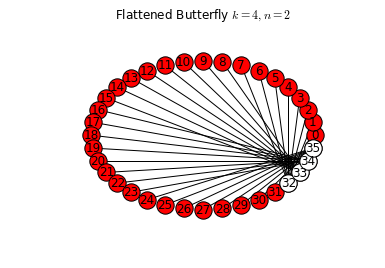

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
import math
class FlattenedButterfly(object):
    def __init__(self,k,n):
        self.k = k
        self.n = n
        self.num_of_switches = int(math.pow(k,n-1))
        self.num_of_servers = int(math.pow(k,n))*2
        self.switches_ids = [self.num_of_servers+i for i in range(self.num_of_switches)]
        self.topo = nx.Graph()
        self.generateTopo(self.topo)
    def generateTopo(self,topo):
        k = self.k
        n = self.n
        # the i-th switch (i is not the id of switch) connects with servers: [2*k,2*k+2*k-1]
        for i in range(self.num_of_switches):
            servers = [s for s in range(2*self.k*i,2*self.k*i+2*self.k)]
            print servers
            # connect servers and switch
            for s in servers:
                topo.add_edge(s,self.switches_ids[i])
        # connect switches
        for i in range(self.num_of_switches):
            for d in range(1,n):
                for m in range(0,k):
                    j = self.compute_j(i,m,k,d)
                    if i != j and j < len(self.switches_ids) and j >= 0:
                        topo.add_edge(self.switches_ids[i],self.switches_ids[j])
                        
        
    def compute_j(self,i,m,k,d):
        temp = int(math.pow(k,d-1))
        j = i + temp*(m - (int(math.floor(i*1.0/temp))))
        return j
        
    def show(self):
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        
        plt.title(r"Flattened Butterfly $k = {}, n = {}$".format(self.k,self.n))
        plt.axis('off')
        plt.show()
          
fb = FlattenedButterfly(4,2)
fb.show()

In [19]:
import random
x = [9,90,12,4]
print random.choice(x)

90


[0, 1, 2]
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


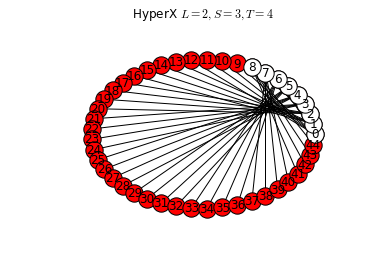

In [46]:
% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import math
class HyperX(object):
    
    def __init__(self,L,S,T):
        self.L = L
        self.S = S
        self.T = T
        self.topo = nx.Graph()
        self.num_of_switches = int(math.pow(S,L))
        self.num_of_servers = T*self.num_of_switches
        self.switches_ids= [i for i in range(self.num_of_switches)]
        self.switches_prefs = self.generate_prefs()
        self.prefs_to_id = self.convert_pref_to_id()
        self.generate_topo()
    def generate_prefs(self):
        
        x = [i for i in range(self.S)]
        ret = list(itertools.product(x,repeat=self.L))
        #print "pref: "
        print x
        print ret
        return ret
    def convert_pref_to_id(self):
        d = {}
        for i in range(len(self.switches_prefs)):
            d[self.switches_prefs[i]] = i
        #print d
        return d
    def generate_topo(self):
        # 省点事吧...life is short
        # switch to switch
        for sw1 in self.switches_prefs:
            for sw2 in self.switches_prefs:
                if sw1 != sw2:
                    if sw1[0] == sw2[0] or sw1[1] == sw2[1]:
                        # connnet each other
                        one  = self.prefs_to_id[sw1]
                        another = self.prefs_to_id[sw2]
                        self.topo.add_edge(one,another)
        # switch to server
        for sw in self.switches_ids:
            servers = [s+self.num_of_switches for s in range(sw*self.T,(sw+1)*self.T)]
            for server in servers:
                self.topo.add_edge(server,sw)
        
    def show(self):
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        #print self.topo.edges()
        plt.title(r"HyperX $L = {}, S = {}, T = {}$".format(self.L,self.S,self.T))
        plt.axis('off')
        plt.show()
                
        
        
h = HyperX(L=2,S=3,T=4)
h.show()


In [28]:
d = {(0,0):1}
d

{(0, 0): 1}

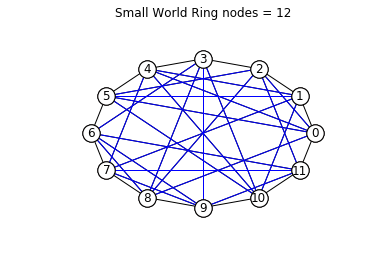

In [97]:
# Small World topology: Ring
% matplotlib inline
import networkx as nx
import simpy
import matplotlib.pyplot as plt
import random
class SWRing(object):
    """
    k个点组成首位相接的环；每个点再和其他任意四个点相连
    
    随机连接后，不一定保证每个节点的度都为6。因为，前面的节点连完以后，可能导致后面的节点没法连了。
    随便连接很有可能不成功，要多试几次
    
    """
    def __init__(self,k):
        self.k = k
        self.num_switches = k
        self.switches_ids = [i for i in range(self.k)]
        self.topo = nx.Graph()
        self.random_links = []
        
        self.generate_topo()
        
        
    def generate_topo(self):
        self.success = True # 如果构建完的拓扑不满足条件，那么重新构建一次
        # 先构建环
        for i in range(self.k):
            self.topo.add_edge(i,(i+1)%(self.k))
        # 然后每个节点随机连接四条线
        # 每个点的度数限制为6
        for node in range(self.k):
            already_connected = self.topo.adj[node].keys() #node已经连接的节点
            #print str(node)+" old connections: ",
            #print already_connected
            while len(already_connected)<6:
                left = [i for i in range(self.k) if i not in already_connected and i != node and self.topo.degree(i)<6]
#                 print node,
#                 print "already connections = ",
#                 print already_connected
#                 print "left = ",
#                 print left
                if len(left) == 0:
                    self.success = False
                    break
                random_one = random.choice(left)

                already_connected.append(random_one)
                self.topo.add_edge(random_one,node)
        
                self.random_links.append((random_one,node))
            
                
    def show(self):
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        nx.draw_networkx_edges(self.topo,pos,self.random_links,edge_color='b')
        plt.title(r"Small World Ring nodes = {}".format(self.k))
        plt.axis('off')
        plt.show()
        
ring = SWRing(12)
#print ring.topo.node
#print ring.topo.adj[3].keys()
#print dir(ring.topo)
# 我真是太机智了
while ring.success == False:
    ring  = SWRing(12)
ring.show()

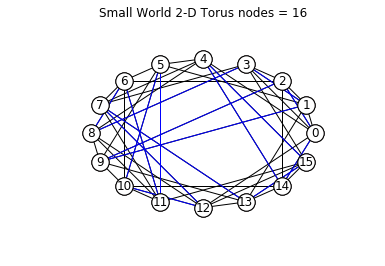

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [105]:
# Small World topology: 2D
% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random
# k*k lattice with random links
class SW2D(object):
    def __init__(self,k):
        self.k = k
        self.num_of_switches = k**2
        self.num_of_all = k**2
        self.switches_ids = [i for i in range(self.k**2)]
        self.topo = nx.Graph()
        self.random_links = []
        self.generate_topo()
    def generate_topo(self):
        self.success = True
        # 先画lattice
        # 先连接 k-1行
        k =  self.k
        # i : 每个i连接2个节点
        for i in range(k**2-k):
            # 如果i不是最后一列的节点
            if (i+1)%k != 0:
                self.topo.add_edge(i,i+1) # 和右边的节点连接
                self.topo.add_edge(i,k+i) # 和下面的节点连接
            else:
                self.topo.add_edge(i,k+i)
        # 再连接最后一行
        for i in range(k**2-k,k*k-1):
            self.topo.add_edge(i,i+1)
            
        # 最后每一列（行）的首位连
        for i in range(k):
            self.topo.add_edge(i,k**2-k+i)# 第一行的节点和最后一行的节点分别相连
        rows = map(lambda x: x*k,[i for i in range(k)])# 得到第一列的数
        for i in rows:
            self.topo.add_edge(i,i+k-1) # 每一行的第一个元素和该行的最后一个元素相连
            
        # random links
        
        for node in range(k**2):
            already_connected = self.topo.adj[node].keys()
            while len(already_connected)<6:
                left =[i for i in range(k**2) if i != node and i not in already_connected and self.topo.degree(i)<6]
#                 print node,
#                 print "already connections = ",
#                 print already_connected
#                 print "left = ",
#                 print left
                if len(left) == 0:
                    self.success  =  False
                    break
                random_one = random.choice(left)
                already_connected.append(random_one)
                self.topo.add_edge(random_one,node)
                self.random_links.append((random_one,node))
        
        
        
    def show(self):
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        nx.draw_networkx_edges(self.topo,pos,self.random_links,edge_color='b')
        plt.title(r"Small World 2-D Torus nodes = {}".format(self.k**2))
        plt.axis('off')
        plt.show()
        
sw = SW2D(4)
while sw.success == False:
    sw = SW2D(4)
sw.show()
print sw.topo.nodes()
# for node in sw.topo.nodes():
#     print str(node)+" neighbors: ",
#     print sw.topo.adj[node].keys()

In [63]:
k = 4
x = map(lambda y,k=4: y*k,[i for i in range(k)])
x

[0, 4, 8, 12]

0:  [8, 1, 28]
1:  [0, 9, 2, 12, 7]
2:  [40, 1, 3]
3:  [9, 2, 19, 4, 60]
4:  [3, 5, 31]
5:  [35, 4, 11, 53, 57, 61]
6:  [56, 36, 12, 7]
7:  [8, 1, 51, 6]
8:  [0, 9, 41, 14, 7]
9:  [8, 1, 10, 3, 16]
10:  [9, 11, 16, 50, 52, 25]
11:  [10, 5, 62, 45]
12:  [40, 1, 13, 6]
13:  [17, 19, 12, 14]
14:  [8, 13, 62, 15]
15:  [38, 14, 47, 16, 21, 63]
16:  [64, 17, 10, 9, 15]
17:  [16, 57, 35, 13, 23]
18:  [31, 19, 63]
19:  [18, 3, 20, 13, 37]
20:  [33, 68, 19, 21, 24, 28]
21:  [71, 20, 22, 15]
22:  [40, 21, 23]
23:  [17, 43, 22]
24:  [25, 20]
25:  [24, 26, 10, 31]
26:  [25, 27, 68, 65]
27:  [33, 39, 26, 28, 58, 30]
28:  [0, 27, 20, 29, 46]
29:  [35, 28, 37]
30:  [27, 36, 31]
31:  [32, 4, 18, 25, 60, 30]
32:  [33, 38, 49, 52, 58, 31]
33:  [32, 34, 27, 20]
34:  [40, 33, 58, 35, 54]
35:  [17, 34, 29, 5]
36:  [48, 6, 46, 37, 30]
37:  [19, 43, 36, 29, 38]
38:  [32, 15, 37, 46, 39]
39:  [40, 66, 27, 45, 38]
40:  [34, 39, 41, 12, 2, 22]
41:  [40, 8, 51, 47]
42:  [43, 47]
43:  [42, 58, 44, 37, 23]
44:  [4

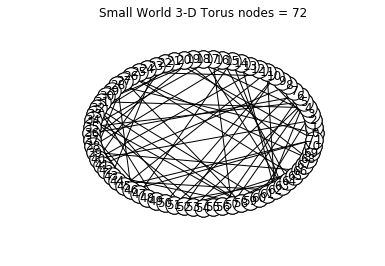

In [140]:
# Small World Topology : 3D
% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random
# 三层。。。有点复杂
class SW3D(object):
    def __init__(self,k):
        self.k = k
        self.n = k*(k-2) # 每层的个数...这只是图的其中一部分，为了方便计算，取k-2行
        self.topo = nx.Graph()
        self.num_of_switches = self.n*3
        self.switches_ids = [i for i in range(self.n*3)]
        self.num_of_nodes = self.n*3
        self.random_links = []
        self.generate_topo()
    def generate_topo(self):
        k = self.k
        n = self.n
        self.success = True
        for i in range(3):
            # 先连横线
            ids = [i for i in range(i*n,(i+1)*n)]
            
            for node in ids:
                # 如果node不是最后一列的节点，则它和右边的节点相连
                if (node+1)%k != 0:
                    
                    self.topo.add_edge(node,node+1)
                # 再连接竖线(最后一行不连，到底了)
                # 该点所在的行数
                row = (node%n)/k
                if row < k-3 and row%2 == 0:
                    if node%2 == 1:
                        self.topo.add_edge(node,node+k)
                if row < k-3 and row%2 == 1:
                    if node%2 == 0:
                        self.topo.add_edge(node,node+k)
            # 不同维度之间的节点互相连
            if i == 0 or i == 1:
                self.topo.add_edge(node,node+n)
            
        # 随机连接一条
        for node in self.switches_ids:
            already_connected = self.topo.adj[node].keys()
            left = [i for i in range(self.num_of_switches) if i != node and i not in already_connected and self.topo.degree(i)<6]
            if len(left) == 0:
                self.success = False
                break
            random_one = random.choice(left)
            already_connected.append(random_one)
            self.random_links.append((node,random_one))
            self.topo.add_edge(random_one,node)
        
            
    def show(self):
        
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        #nx.draw_networkx_edges(self.topo,pos,self.random_links,edge_color='b')
        plt.title(r"Small World 3-D Torus nodes = {}".format(self.k*(self.k-2)*3))
        plt.axis('off')
        plt.show()

sw3d = SW3D(6)
while sw3d.success == False:
    sw3d = SW3D(6)
for node in sw3d.topo.nodes():
    print str(node)+": ",
    print sw3d.topo.adj[node].keys()
print sw3d.topo.edges()
sw3d.show()                     

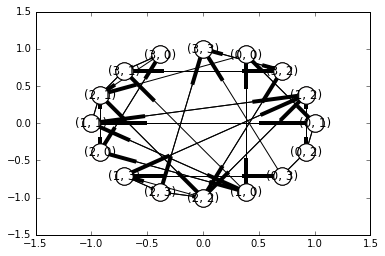

In [117]:
% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random
topo = nx.navigable_small_world_graph(n=4, p=1, q=1, r=1, dim=2, seed=None)
pos  = nx.circular_layout(topo)
nx.draw_networkx(topo,pos)
nx.draw_networkx_nodes(topo,pos,node_color='w')
plt.show()

[4, 5]
[4, 5]
[6, 7]
[6, 7]
[8, 9]
[8, 9]
[10, 11]
[10, 11]
0:  [8, 10, 4, 6]
1:  [8, 11, 4, 7]
2:  [9, 10, 5, 6]
3:  [9, 11, 5, 7]
4:  [0, 1, 12, 13]
5:  [2, 3, 12, 13]
6:  [0, 2, 14, 15]
7:  [1, 3, 14, 15]
8:  [0, 1, 16, 17]
9:  [16, 17, 2, 3]
10:  [0, 2, 19, 18]
11:  [19, 1, 18, 3]
12:  [4, 5]
13:  [4, 5]
14:  [6, 7]
15:  [6, 7]
16:  [8, 9]
17:  [8, 9]
18:  [10, 11]
19:  [10, 11]


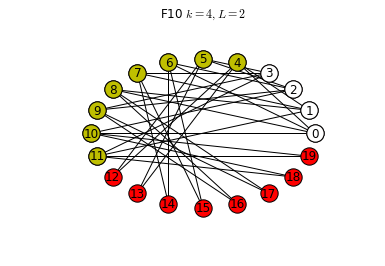

In [24]:
# F10
#% matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
# 暂时只适用于L＝3的情况
class F10(object):
    
    class Pod(object):
        def __init__(self,id,k,L=3):
            self.id = id
            self.k = k
            self.L = L
            self.p = k/2
            self.contains = self.generate_contains()# 包含的中间一层的交换机，最下层先不考虑
        def generate_contains(self):
            p = self.p
            L = self.L
            p2L = int(math.pow(p,L))
            ret = []
            for i in range(self.id*p+p2L,self.id*p+p2L+p):
                ret.append(i)
            return ret
    
    
    def __init__(self,k,L=3):
        self.k = k
        self.L = L
        self.p = k/2
        self.num_of_switches = 5*(int)(math.pow(k/2,L)) 
        self.num_of_node = self.num_of_switches
        self.num_of_cores = (int)(math.pow(k/2,L))
        self.switches_ids = [i for i in range(self.num_of_switches)]
        self.core_ids = [i for i in range(self.num_of_cores)]
        self.middle_ids = [i+self.num_of_cores for i in range(2*(int)(math.pow(k/2,L)))]
        self.pods = [F10.Pod(i,k,L) for i in range(2*(int)(math.pow(k/2,L-1)))]
        self.topo = nx.Graph()
        self.generate_topo()
    def generate_topo(self):
        for pod in self.pods:
            for i in range(len(pod.contains)):
                sw = pod.contains[i] # 第i个交换机为sw
                print pod.contains
                # A树
                if pod.id%2 == 0:
                    switches_up = [s for s in range(i*self.p,(i+1)*self.p)]# 和当前的交换机连接的上层交换机
                    for switch in switches_up:
                        self.topo.add_edge(sw,switch)
                # B树
                else:
                    switches_up = [s for s in range(self.num_of_cores) if s%2 == i %2]
                    for switch in switches_up:
                        self.topo.add_edge(sw,switch)
                # 连接最下面一层
                t = (int)(math.pow(self.p,self.L)) # t = pow(p,L)
                # 当前 pod对应的最下面的交换机
                switches_down = [s for s in range(pod.id*self.p+3*t,3*t+(pod.id+1)*self.p)]
                #print switches_down
                for switch in switches_down:
                    self.topo.add_edge(sw,switch)
    def show(self):
        
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.core_ids,node_color='w')
        nx.draw_networkx_nodes(self.topo,pos,self.middle_ids,node_color='y')
        plt.title(r"F10 $k={},L={}$".format(self.k,self.L))
        plt.axis('off')
        plt.show()              
                    
                
f10 = F10(k=4,L=2)
for node in f10.topo.nodes():
    print str(node)+": ",
    print f10.topo.adj[node].keys()
f10.show()

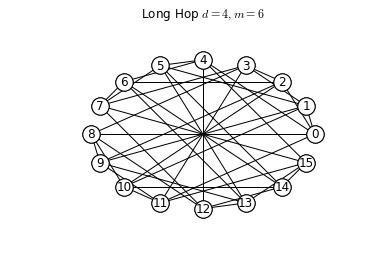

In [64]:
# Long Hop
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import itertools
# class Topo(object):
    
    
    
#     def __init__(self):
#         self.num_of_switches = 0
        
#         self.num_of_servers = 0
        
#         self.num_of_node = self.num_of_servers + self.num_of_switches
        
#         self.switches_ids = [i for i in range(self.num_of_switches)]
#         self.topo = nx.Graph()
#         self.generate_topo()
#     def generate_topo(self):
#         pass
#     def show(self):
        
#         pos = nx.circular_layout(self.topo)
#         nx.draw_networkx(self.topo,pos)
#         nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        
#         plt.axis('off')
#         plt.show()              
                   
class LongHop(object):
    def __init__(self,d,m):
        self.d = d
        self.m = m
        self.num_of_switches = int(math.pow(2,d))
        self.num_of_nodes = self.num_of_switches
        self.switches_ids = [i for i in range(self.num_of_switches)]
        self.topo = nx.Graph()
        self.generate_topo()
    def generate_topo(self):
        # 节点：使用二进制表示
        nodes = list(itertools.product([0,1],repeat=self.d))
#         print "Nodes: ",
#         print nodes
        A = np.eye(self.d,dtype=int)
        B = np.zeros((self.d,(self.m - self.d)),dtype=int)
        
        for r in range(self.d):
            for c in range(self.m-self.d):
                B[r][c] = random.choice([0,1])
        G_temp = np.hstack((A,B))
        G = G_temp.transpose()
#         print "rows in G"
#         for row in G:
#             print row
            
        for x in nodes:
            # 每个节点x和m个二进制数相异或（矩阵正好是m行）
            # 将得到的二进制数，转化为十进制数d。
            # x和d相连
            for row in G:
                h = []
                for c in row:
                    h.append(c)
                node_binary = self.XOR(x,h)
                #print node_binary,
                #print(" 转化为十进制为： ")
                node = self.convert2int(node_binary)
                #print node
                self.topo.add_edge(self.convert2int(x),node)
                
        
    def XOR(self,list_a,list_b):
        ret = []
        assert len(list_a) == len(list_b)
        for i in range(len(list_a)):
            temp = list_a[i]^list_b[i]
            ret.append(temp)
        return ret
    def convert2int(self,li):
        length = len(li)
        s = 0
        for i in range(length):
            s = s*2 + li[i]
        return s
    
    def show(self):
        
        pos = nx.circular_layout(self.topo)
        nx.draw_networkx(self.topo,pos)
        nx.draw_networkx_nodes(self.topo,pos,self.switches_ids,node_color='w')
        plt.title(r"Long Hop $d = {}, m = {}$".format(self.d,self.m))
        plt.axis('off')
        plt.show() 

        
lh = LongHop(4,6)
lh.show()

In [48]:
import itertools

print list(itertools.product([0,1],repeat=3))

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
